In [1]:
import numpy as np
from matplotlib import pyplot as plt

def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return np.array(x_sample), np.array(y_sample)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(1000, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(1000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
X, y = get_multivariate_sample(1000, 40, 0)


In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math


def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .32)


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.6876964338632626

In [4]:
from scipy.stats import entropy

def get_entropy(X):
    probs = np.bincount(X)/len(X)
    return entropy(probs)

In [5]:
def get_mutual_information(X, y, n_estimators = 300, max_samples = .32, depth = 30):
    cond_entropy = rf_entropy_estimate_bagging(X, y, n_estimators = n_estimators, max_samples = max_samples, depth = depth)
    h_y = get_entropy(y)
    return h_y - cond_entropy

In [6]:
get_mutual_information(X, y)

0.006061612122094551

In [9]:
from tqdm import tqdm_notebook

def mutual_information_v_mu(n, d):
    means = [i*-.2 for i in range(0, 26)]
    means.reverse()
    means.extend([i*.2 for i in range(1, 26)])
    mutual_infos = []
    for mean in tqdm_notebook(means):
        X, y = get_multivariate_sample(n, d, mean)
        mutual_info = get_mutual_information(X, y)
        mutual_infos.append(mutual_info)
    return means, mutual_infos
    
    

In [10]:
means, mutual_infos = mutual_information_v_mu(20000, 6)

In [11]:
import pickle
pickle.dump({"means": means, "mutual_infos": mutual_infos}, open("mutual_info_cef.p", "wb"))

In [20]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import math
from sklearn import mixture

def estimate_p(y):
    return y.count(1)/len(y)

def estimate_x_params(X):
    model = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
    model.fit(X)
    return model.means_, model.covariances_
    
estimate_x_params(X)

def normal_entropy_f(t, mean, var):
    return -norm.pdf(t, mean, var)*np.log(norm.pdf(t, mean, var))

def two_mixture_normals_entropy_f(t, mean_1, mean_2, var_1, var_2):
    return -.5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2)) - .5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2))

def normal_entropy(var):
    return .5*np.log(2*math.pi*math.e*var)

#NOTE: this doesn't work for mean = 0
def plugin_estimate_cat_1D(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    #h_x_cond_y = integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][0], x_params[1][0].item()))[0]*.5 + \
    #integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][1], x_params[1][1].item()))[0]*.5
    h_x_cond_y = normal_entropy(x_params[1][0])*.5 + normal_entropy(x_params[1][1])*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (x_params[0][0], x_params[0][1], x_params[1][0].item(), x_params[1][1].item()))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy

def truth_1d(mean):
    h_y = -.5*np.log(.5) - .5*np.log(.5)
    h_x_cond_y = normal_entropy(1)*.5 + normal_entropy(1)*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (mean, -mean, 1, 1))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy


def mutual_information_truth():
    entropy = -.5*np.log(.5) - .5*np.log(.5)
    means = [i*-.2 for i in range(0, 26)]
    means.reverse()
    means.extend([i*.2 for i in range(1, 26)])
    truths = []
    for elem in means:
        truths.append(entropy - truth_1d(elem))
    #return means, cef_all, plugin_all, truth
    return truths

In [27]:
truths = mutual_information_truth()
kraskov = [1.0000267195906574,
 1.0000194483801206,
 0.9999970028162668,
 1.0000286816652846,
 0.9999567520284547,
 1.0000074377896926,
 0.9993845779811412,
 0.9994575886283723,
 0.9991158314500801,
 0.9962658789225962,
 0.9932241102642436,
 0.9895311566293579,
 0.9839485557251191,
 0.9712889586912858,
 0.9471418912095793,
 0.9194403914718272,
 0.8674987247299182,
 0.8008579489515029,
 0.7206384753870108,
 0.6161068592406238,
 0.49659548677936804,
 0.357949007829653,
 0.2241162853866463,
 0.11061271212156676,
 0.03723346251871007,
 0.01362611805547509,
 0.030891275942973806,
 0.11651600102990223,
 0.23608543318966468,
 0.36337163989797716,
 0.477140595701286,
 0.6239253027783906,
 0.7210893540423857,
 0.8120047144065445,
 0.8736670752521913,
 0.9259827154642739,
 0.946259230769515,
 0.9737396241846508,
 0.9846713949308601,
 0.9880041569312574,
 0.9958322337963192,
 0.9970999217182417,
 0.999623790151615,
 0.9996597184081111,
 0.9996027698384022,
 1.0000357148142864,
 1.0000055911413561,
 1.0000319133008997,
 0.9998563186857901,
 0.9999695878716199,
 1.0000351954452054]

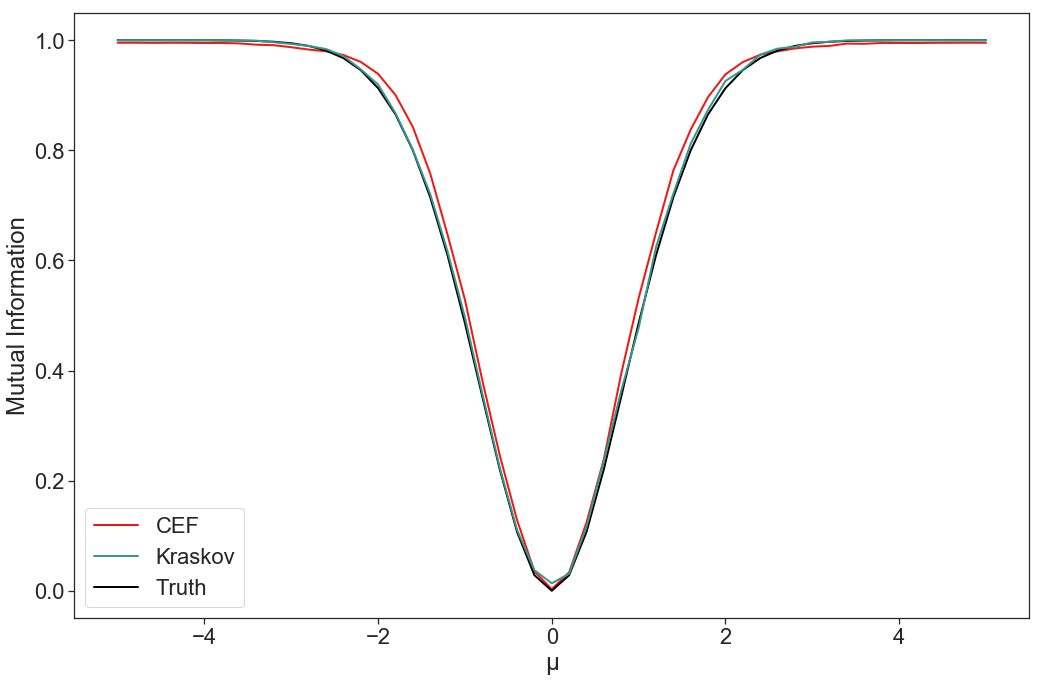

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
entropy = -.5*np.log(.5) - .5*np.log(.5)
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cef, = plt.plot(means, np.array(mutual_infos)/entropy, label = "CEF", linewidth = 2, color = "#F41711")
line_truth, = plt.plot(means, np.array(truths)/entropy, label = "Truth", linewidth = 2, color = "black")
line_kraskov, = plt.plot(means, kraskov, label = "Kraskov", linewidth = 2, color = "#35978f")


plt.xlabel(u'\u03bc')
plt.ylabel("Mutual Information")
#plt.ylim(ymin = 0)
#plt.ylim(ymax = .9)
plt.legend(handles=[line_cef, line_kraskov, line_truth])
plt.tight_layout()
plt.savefig("mi_normalized.png")
plt.show()

In [30]:
mutual_infos_20 = [1.0000354839950276,
 0.9999910485067787,
 0.9999759743725605,
 0.9999750125553675,
 0.9997839842357976,
 0.9991687000102516,
 0.9999606375382086,
 0.9991789242953644,
 0.9975915026445819,
 0.996807424854083,
 0.9907806382430806,
 0.9836241217575434,
 0.9715542977658131,
 0.9507646771088218,
 0.9187496475244004,
 0.8750185129586328,
 0.8093134983487502,
 0.7071686407038342,
 0.5991751392217495,
 0.4607362309977603,
 0.32111773492554363,
 0.1430984562109643,
 0.0023275045742252587,
 0.12009295734919334,
 0.19525618648376053,
 0.2428670950966847,
 0.2043629049439346,
 0.13118432490680476,
 0.008383575203431803,
 0.13862753415681084,
 0.3035453741858163,
 0.4710500662784014,
 0.5908479276489587,
 0.7055464558885731,
 0.8080395044058974,
 0.8637403005683737,
 0.9191393679299438,
 0.9536720494488691,
 0.9749467705746184,
 0.9844230449866558,
 0.9903084113700942,
 0.9962376335859275,
 0.9981321356903621,
 0.9996536570374062,
 0.9994293128457414,
 0.999832211696571,
 0.9999942906593233,
 1.000036061049805,
 0.9999997048562719,
 1.0000158055255355,
 1.0000214609307676]

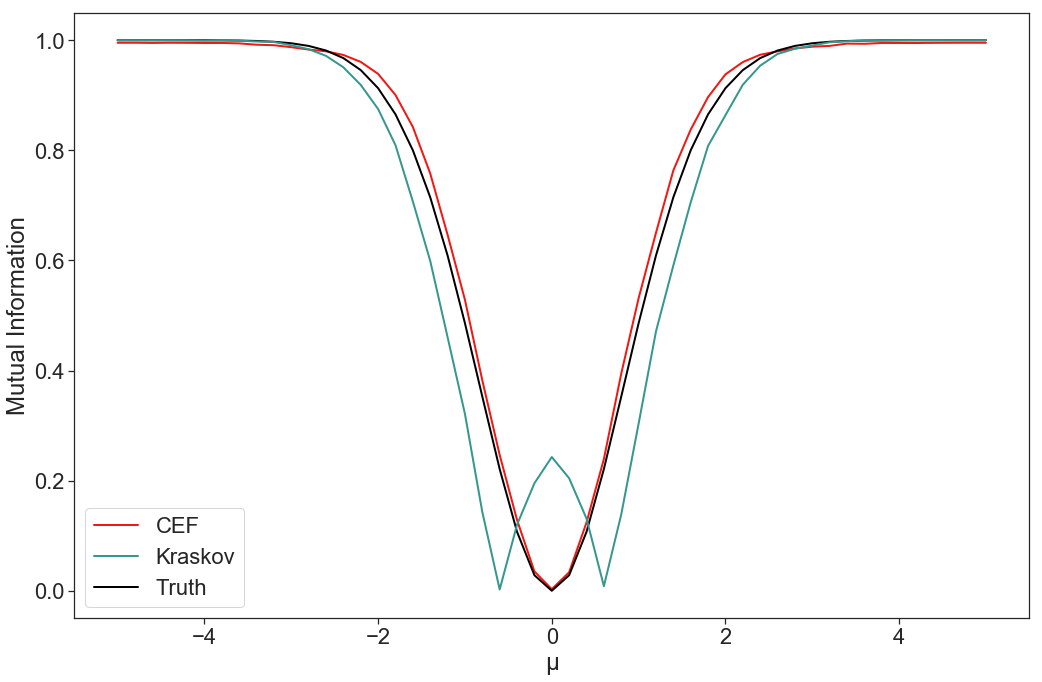

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
entropy = -.5*np.log(.5) - .5*np.log(.5)
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cef, = plt.plot(means, np.array(mutual_infos)/entropy, label = "CEF", linewidth = 2, color = "#F41711")
line_truth, = plt.plot(means, np.array(truths)/entropy, label = "Truth", linewidth = 2, color = "black")
line_kraskov, = plt.plot(means, mutual_infos_20, label = "Kraskov", linewidth = 2, color = "#35978f")


plt.xlabel(u'\u03bc')
plt.ylabel("Mutual Information")
#plt.ylim(ymin = 0)
#plt.ylim(ymax = .9)
plt.legend(handles=[line_cef, line_kraskov, line_truth])
plt.tight_layout()
plt.show()